In [1]:
import os
import re
import sys
import json
import codecs
import locale
import logging
import requests
import datetime as dt
from typing import Union, Optional, Tuple, List, cast

from matplotlib import pyplot as plt    # type: ignore  
import matplotlib.gridspec as gridspec  # type: ignore     

import tabula
from tabula import read_pdf

import pandas as pd
import numpy as np

In [2]:
#----------------------------------------------------------------
# Configurations section
#----------------------------------------------------------------

temp_content_dir = os.path.join(os.sep, 'tmp')
images_path = os.path.join("..","images")

now = dt.datetime.now()
sample_date = now.strftime("%d/%m/%Y")

locale.setlocale(locale.LC_ALL, 'it_IT.UTF-8')

ok_statuses = [200, 201, 202]
data_file_path = os.path.join("..","data")
tmp_data_file_path = os.path.join(os.sep,"tmp")

csv_data_file = os.path.join(data_file_path, "vaccinazioni.csv")



In [3]:
#----------------------------------------------------------------
# Import the procedures that download and transform the pdf file
# into a dataframe.
#----------------------------------------------------------------

module_path = os.path.abspath(os.path.join('..','src'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ChartTools      import text_box    
from VacciniDownload import download_csv_file
from VacciniDownload import create_dataframe
from VacciniDownload import chart_vaccinations_male_female
from VacciniDownload import age_distribution
from VacciniDownload import chart_vaccinations_fornitore
from VacciniDownload import plot_vaccinations_by_time

from VacciniDownload import init_logger

init_logger('/tmp', "vaccini-notebook.log",log_level=logging.DEBUG, std_out_log_level=logging.ERROR)

/home/giovanni/code-personal/python/Virus/src


In [8]:
print(csv_data_file)
result = create_dataframe(data_file=csv_data_file)
if result.is_ok():
    df = result.value()
else:
    print(result.value())
    assert(False)
print("Last date {d}".format(d=df["data_somministrazione"].max()))    
(df.shape, df.dtypes)

../data/vaccinazioni.csv
Last date 2021-03-09 00:00:00


((18021, 19),
 data_somministrazione                         datetime64[ns]
 fornitore                                             object
 area                                                  object
 fascia_anagrafica                                     object
 sesso_maschile                                         int64
 sesso_femminile                                        int64
 categoria_operatori_sanitari_sociosanitari             int64
 categoria_personale_non_sanitario                      int64
 categoria_ospiti_rsa                                   int64
 categoria_over80                                       int64
 categoria_forze_armate                                 int64
 categoria_personale_scolastico                         int64
 prima_dose                                             int64
 seconda_dose                                           int64
 codice_NUTS1                                          object
 codice_NUTS2                                          o

In [9]:
df.head(5)

,data_somministrazione,fornitore,area,fascia_anagrafica,sesso_maschile,sesso_femminile,categoria_operatori_sanitari_sociosanitari,categoria_personale_non_sanitario,categoria_ospiti_rsa,categoria_over80,categoria_forze_armate,categoria_personale_scolastico,prima_dose,seconda_dose,codice_NUTS1,codice_NUTS2,codice_regione_ISTAT,nome_area,totali
0,2020-12-27,Pfizer/BioNTech,ABR,20-29,1,0,1,0,0,0,0,0,1,0,ITF,ITF1,13,Abruzzo,1
1,2020-12-27,Pfizer/BioNTech,ABR,30-39,1,3,4,0,0,0,0,0,4,0,ITF,ITF1,13,Abruzzo,4
2,2020-12-27,Pfizer/BioNTech,ABR,40-49,1,6,7,0,0,0,0,0,7,0,ITF,ITF1,13,Abruzzo,7
3,2020-12-27,Pfizer/BioNTech,ABR,50-59,4,5,9,0,0,0,0,0,9,0,ITF,ITF1,13,Abruzzo,9
4,2020-12-27,Pfizer/BioNTech,ABR,60-69,10,4,13,1,0,0,0,0,14,0,ITF,ITF1,13,Abruzzo,14


In [16]:
mask = df["nome_area"] == "Lombardia"
df.loc[mask,["data_somministrazione","nome_area","fornitore","sesso_maschile","sesso_femminile","fascia_anagrafica"]].head(4)

,data_somministrazione,nome_area,fornitore,sesso_maschile,sesso_femminile,fascia_anagrafica
50,2020-12-27,Lombardia,Pfizer/BioNTech,20,22,20-29
51,2020-12-27,Lombardia,Pfizer/BioNTech,30,31,30-39
52,2020-12-27,Lombardia,Pfizer/BioNTech,61,77,40-49
53,2020-12-27,Lombardia,Pfizer/BioNTech,112,115,50-59


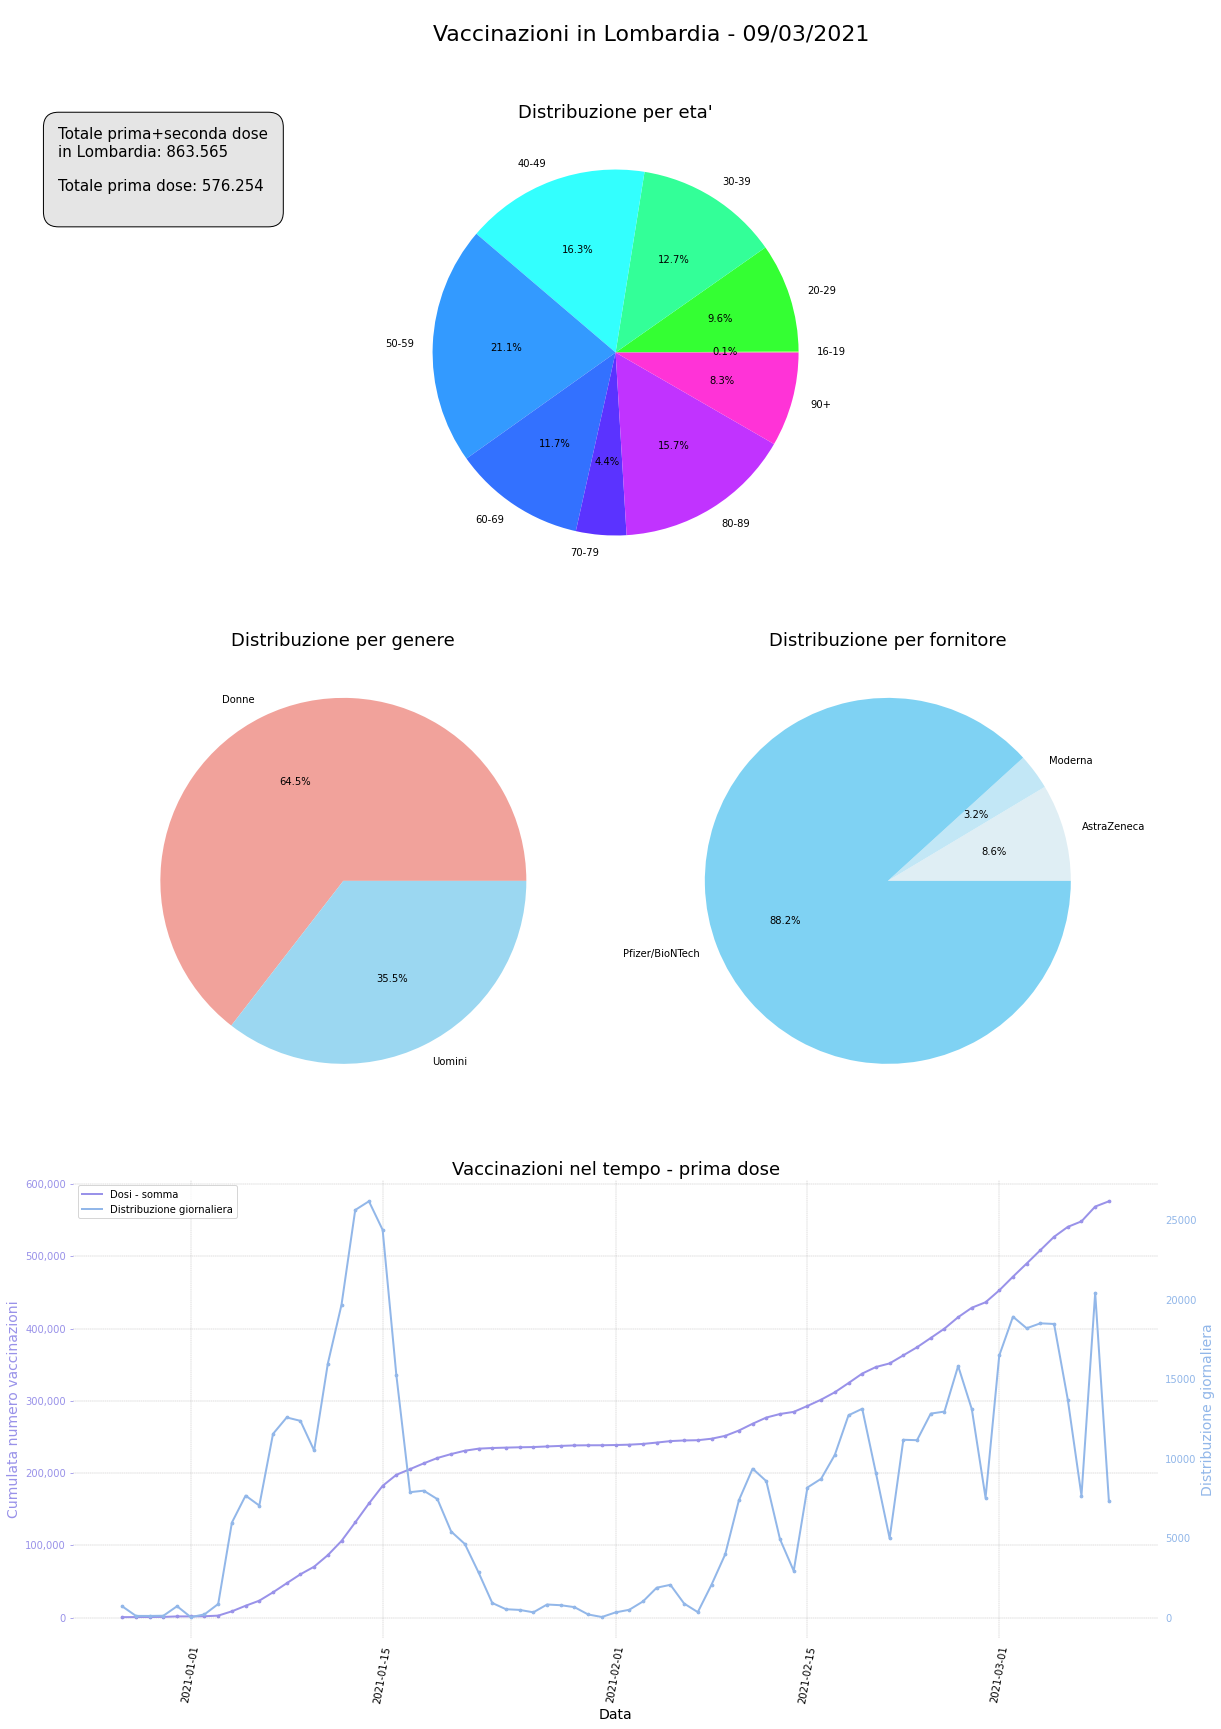

In [7]:
regions = ["Lombardia","Lazio"]
region_name = regions[0]
mask_region = (df["nome_area"] == region_name)
df_region = df.loc[mask_region, ["data_somministrazione", "totali", 'fascia_anagrafica', "sesso_maschile","sesso_femminile", "fornitore", "prima_dose", "seconda_dose"]]

last_date = df["data_somministrazione"].max()
total_male = df_region["sesso_maschile"].sum()
total_female = df_region["sesso_femminile"].sum()
total = total_male + total_female
total_first_injection = df_region["prima_dose"].sum()

fig = plt.figure(figsize=(20, 30))
gs1 = gridspec.GridSpec(4, 3
                       ,figure=fig 
                       ,hspace=0.2
                       ,wspace=0.01
                       ,height_ratios=[1, 10, 10, 10]
                       ,width_ratios=[1, 20, 20])
ax = []

idx = 0
ax.append(fig.add_subplot(gs1[0,:]))
text_box(ax[idx], "Vaccinazioni in {re} - {dt}".format(dt=last_date.strftime('%d/%m/%Y')
                                                      ,re=region_name), x=0.35,y=0.4, fontsize=22)

idx += 1
ax.append(fig.add_subplot(gs1[1,0]))
text_box(ax[idx], """Totale prima+seconda dose\nin {r}: {t}

Totale prima dose: {pd}
"""
                  .format(r=region_name
                         ,pd=locale.format_string('%d', total_first_injection, grouping=True) 
                         ,t=locale.format_string('%d', total, grouping=True))
        ,x=0.6,y=0.9, fontsize=15,colors=["#e5e5e5", "#000000", "#000000"])

idx += 1
ax.append(fig.add_subplot(gs1[1,1:]))
result = age_distribution(df_region, ax=ax[idx], gender="B")

idx += 1
ax.append(fig.add_subplot(gs1[2,1]))
result = chart_vaccinations_male_female(df_region, ax=ax[idx])

idx += 1
ax.append(fig.add_subplot(gs1[2,2]))
result = chart_vaccinations_fornitore(df_region, ax=ax[idx])

idx += 1
ax.append(fig.add_subplot(gs1[3,1:]))
result = plot_vaccinations_by_time(df_region, ax=ax[idx])

output_format = "JPEG"
plt.savefig(os.path.join(images_path,"{prefix}-Vaccinazioni-{r}.{fmt}".format(fmt=output_format
                                                                            ,r=region_name 
                                                                            ,prefix=last_date.strftime('%Y%m%d')))
          ,format=output_format
          ,bbox_inches='tight'
          ,pad_inches=0.5)

In [19]:
style_list = ['default', 'classic'] + sorted(style for style in plt.style.available if style != 'classic')
style_list

['default',
 'classic',
 'Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [6]:
region_name = "Lombardia"
mask = (df["nome_area"] == region_name)
df_region = df.loc[mask, ["data_somministrazione", "totali", "sesso_maschile","sesso_femminile", "prima_dose", "seconda_dose"]]
grp_by_time = df_region.groupby("data_somministrazione").sum()
grp_by_time["prima_dose"].cumsum()


data_somministrazione
2020-12-27       702
2020-12-28       805
2020-12-29       905
2020-12-30      1018
2020-12-31      1731
2021-01-01      1755
2021-01-02      1954
2021-01-03      2806
2021-01-04      8782
2021-01-05     16454
2021-01-06     23498
2021-01-07     35053
2021-01-08     47643
2021-01-09     60018
2021-01-10     70528
2021-01-11     86504
2021-01-12    106173
2021-01-13    131729
2021-01-14    157876
2021-01-15    182237
2021-01-16    197492
2021-01-17    205337
2021-01-18    213294
2021-01-19    220718
2021-01-20    226131
2021-01-21    230736
2021-01-22    233572
2021-01-23    234488
2021-01-24    235010
2021-01-25    235490
2021-01-26    235812
2021-01-27    236632
2021-01-28    237401
2021-01-29    238038
2021-01-30    238230
2021-01-31    238262
2021-02-01    238586
2021-02-02    239064
2021-02-03    240021
2021-02-04    241883
2021-02-05    243928
2021-02-06    244809
2021-02-07    245148
2021-02-08    247148
2021-02-09    251021
2021-02-10    258302
2021-02-11  

sesso_maschile    12489
dtype: int64

,sesso_maschile,sesso_femminile,categoria_operatori_sanitari_sociosanitari,categoria_personale_non_sanitario,categoria_ospiti_rsa,categoria_over80,categoria_forze_armate,categoria_personale_scolastico,prima_dose,seconda_dose,codice_regione_ISTAT
fornitore,,,,,,,,,,,
AstraZeneca,66957,89932,29719,33445,215,9,36635,56866,156814,75,6313
Moderna,42258,62065,31688,21620,21038,29720,159,98,87969,16354,28671
Pfizer/BioNTech,1311475,2181776,2191391,606521,356312,336816,728,1483,2163841,1329410,97450


sesso_maschile    66957
dtype: int64